<h2>Network Data Analysis - Coursework 2</h2>

<h3>Task C: Simultaneous Marathon Organization (Voronoi diagrams)</h3>

Despite its accidents, the city of Leeds is ideal for organising marathons. The city mayor would like to organise a day of parallel, simultaneous marathons in different parts of the city. The mayor would like to maximise the participation of citizens by organising these marathons in diverse locations of the city, dividing the city into various areas (or “cells”) so that every person can join a marathon that is close to their home. Within each of these cells, a path of exactly 42 Km is needed. Assuming that the mayor would like to organise N=10 simultaneous marathons: 


**Select the initial set of 10 cell seed points. For this, you can use several criteria, such as being far away from frequent accident roads, being close to public transport, being evenly spread, etc..**

In [1]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import math
import random
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
# Define the city of interest
city = "Leeds, United Kingdom"

# 1. Download road network data from OpenStreetMap both drive and work network types
leeds_road = ox.graph_from_place(city, network_type='drive')
leeds_walk = ox.graph_from_place(city, network_type='walk')
# create a single network for Leeds (drive + walk)
leeds_network = nx.compose_all([leeds_road, leeds_walk])
# get Leeds boundary
leeds_boundary = ox.geocode_to_gdf(city)
# 2. Load road traffic accidents dataset
accidents_data = gpd.read_file('dataset/Leeds_accidents.shp')


Function for finding the nodes where there are least accidents given the Leeds network and Leeds accident data.

In [2]:
def find_least_accident_nodes(graph, accidents_data):
    # Initialize dictionary to store accident counts for each node
    accident_counts = {node: 0 for node in graph.nodes()}
    # Calculate accident counts for each node
    for _, accident in accidents_data.iterrows():
        # Extract latitude and longitude from the 'geometry' column
        latitude, longitude = accident['geometry'].y, accident['geometry'].x
        # Find the nearest node in the graph to the accident location
        nearest_node = ox.distance.nearest_nodes(graph, latitude, longitude)
        # Increment the accident count for the nearest node
        accident_counts[nearest_node] += 1
    # Sort nodes based on accident counts
    sorted_nodes = sorted(accident_counts, key=accident_counts.get)

    return sorted_nodes


Get accident data

In [3]:
least_accident_nodes = find_least_accident_nodes(
    leeds_network, accidents_data)


Function to divide Leeds boundary into equal areas so that we can organise Marathon evenly throughout Leeds.

In [4]:
def divide_leeds_into_cells(leeds_boundary, num_areas=10):
    # Calculate the bounding box of Leeds
    minx, miny, maxx, maxy = leeds_boundary.total_bounds
    # Calculate the width and height of the bounding box
    width = maxx - minx
    height = maxy - miny
    # Calculate the number of rows and columns to divide the bounding box into
    num_cols = math.ceil(math.sqrt(num_areas * (width / height)))
    num_rows = math.ceil(num_areas / num_cols)
    # Calculate the width and height of each area
    area_width = width / num_cols
    area_height = height / num_rows
    # Initialize a list to store the boundaries of each area
    area_boundaries = []

    # Create a grid of areas
    for i in range(num_rows):
        for j in range(num_cols):
            # Calculate the coordinates of the area boundaries
            area_minx = minx + j * area_width
            area_miny = miny + i * area_height
            area_maxx = minx + (j + 1) * area_width
            area_maxy = miny + (i + 1) * area_height

            # Append the area boundaries to the list
            area_boundaries.append(
                (area_minx, area_miny, area_maxx, area_maxy))

    return area_boundaries



Divide Leeds into 10 equal areas.

In [5]:
cell_boundaries = divide_leeds_into_cells(leeds_boundary, 10)
print(len(cell_boundaries))
print(cell_boundaries)


10
[(-1.8004214, 53.6989675, -1.69840744, 53.8224195), (-1.69840744, 53.6989675, -1.59639348, 53.8224195), (-1.59639348, 53.6989675, -1.4943795199999999, 53.8224195), (-1.4943795199999999, 53.6989675, -1.39236556, 53.8224195), (-1.39236556, 53.6989675, -1.2903516, 53.8224195), (-1.8004214, 53.8224195, -1.69840744, 53.9458715), (-1.69840744, 53.8224195, -1.59639348, 53.9458715), (-1.59639348, 53.8224195, -1.4943795199999999, 53.9458715), (-1.4943795199999999, 53.8224195, -1.39236556, 53.9458715), (-1.39236556, 53.8224195, -1.2903516, 53.9458715)]


Function to find the locations where least accidents occurred.
- Using the evenly distributed areas and accident data.

In [6]:
def find_least_accident_area_in_cells(graph, least_accident_nodes, cell_boundaries):
    least_accident_areas = []
    
    for cell_boundary in cell_boundaries:
        minx, miny, maxx, maxy = cell_boundary

        # Create a polygon representing the cell boundary
        cell_polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

        for node in least_accident_nodes:
            # Get latitude and longitude of the node
            latitude, longitude = graph.nodes[node]['y'], graph.nodes[node]['x']
            
            # Create a point from the node coordinates
            point = Point(longitude, latitude)

            # Check if the point is within the cell boundary
            if point.within(cell_polygon):
                least_accident_areas.append(node)
                break

    return least_accident_areas


Seeds criteria:
1. Evenly distributed throughout Leeds.
2. Less accidents

In [7]:
seeds = find_least_accident_area_in_cells(
    leeds_network, least_accident_nodes, cell_boundaries)
print(seeds)


[446295571, 321854, 155002, 319387, 319599, 10389165, 10384093, 3469066, 3468054, 154962]


**Visualise the cells yield by your selection of seed points in a Voronoi diagram.**

Plot the selected seeds in Voronoi diagram

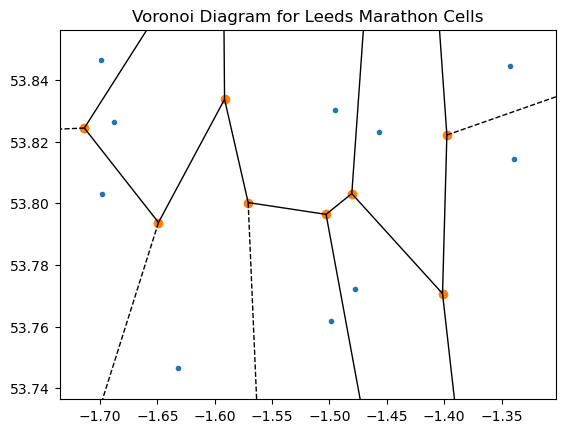

In [8]:
# Convert seed points to a format suitable for Voronoi
coordinates = {node_id: (leeds_network.nodes[node_id]['x'], leeds_network.nodes[node_id]['y']) for node_id in seeds}
points = [coord for coord in coordinates.values()]

# Compute Voronoi diagram
vor = Voronoi(points)

# Plot Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)
ax.set_title('Voronoi Diagram for Leeds Marathon Cells')
plt.show()

Another way to plot the diagram.

C:\Users\patta\AppData\Local\Temp\ipykernel_18836\2832434816.py:15: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  seed_colors = dict(zip(seeds, ox.plot.get_colors(len(seeds))))  # {seed: seed's mapped color}


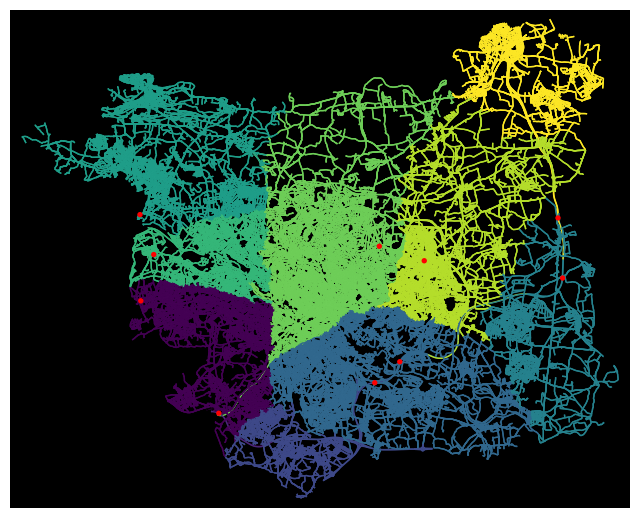

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
all_nodes = list(leeds_network.nodes)

# Black color
black_color = (0.0, 0.0, 0.0, 1.0)

# Finding the node nearest to the given seeds and construct voronoi cells
def nodes_nearest_seed(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells_inverse

node_seed_dict = nodes_nearest_seed(leeds_network, seeds)

# set color of the seeds
def get_seed_color(seeds):
    seed_colors = dict(zip(seeds, ox.plot.get_colors(len(seeds)))) 
    seed_colors['unreachable'] = black_color
    return seed_colors

seed_colors = get_seed_color(seeds)

# map the node color from seeds
def map_node_color_from_seed(graph, seeds, node_seed_dict, seed_colors):
    return {node: seed_colors[node_seed_dict[node]] for node in graph.nodes}

node_color_dict = map_node_color_from_seed(leeds_network, seeds, node_seed_dict, seed_colors)
     
# map edge colors
def map_edge_color_from_node(graph, seeds, node_seed_dict, node_colors, seed_colors):
    edge_colors = []
    for i, e in enumerate(graph.edges):
        color_pair = [node_colors[e[0]], node_colors[e[1]]]
        if black_color in color_pair:  # unreachable
            color_pair.remove(black_color)
            edge_colors.append(color_pair[0])
        elif color_pair[0] == color_pair[1]:
            edge_colors.append(color_pair[0])
        else:
            len_0 = nx.shortest_path_length(graph, node_seed_dict[e[0]], e[0], weight='length')
            len_1 = nx.shortest_path_length(graph, node_seed_dict[e[1]], e[1], weight='length')
            if len_0 <= len_1:  # or discuss on equality cases
                edge_colors.append(color_pair[0])
            else:
                edge_colors.append(color_pair[1])
    return edge_colors
edge_colors = map_edge_color_from_node(leeds_network, seeds, node_seed_dict, node_color_dict, seed_colors)

node_colors = ['r' if node in seeds else 'none' for node in all_nodes]
ox.plot.plot_graph(leeds_network, edge_color=edge_colors, node_color=node_colors, bgcolor ='k')

**Finding 42 km marathon paths**

Extracts the x and y coordinates from a GeoDataFrame containing Point geometries and adds them as separate columns to the same GeoDataFrame

In [10]:
seeds = GeoDataFrame(geometry=[Point(leeds_network.nodes[node]['x'], leeds_network.nodes[node]['y']) for node in seeds])
seeds['x'] = seeds.geometry.x
seeds['y'] = seeds.geometry.y
print(seeds)



                    geometry         x          y
0  POINT (-1.69847 53.80293) -1.698470  53.802925
1  POINT (-1.63198 53.74639) -1.631982  53.746388
2  POINT (-1.49908 53.76173) -1.499078  53.761726
3  POINT (-1.47777 53.77228) -1.477767  53.772284
4  POINT (-1.33899 53.81439) -1.338989  53.814393
5  POINT (-1.69916 53.84628) -1.699159  53.846284
6  POINT (-1.68742 53.82621) -1.687423  53.826214
7  POINT (-1.49521 53.83037) -1.495213  53.830367
8  POINT (-1.45692 53.82309) -1.456922  53.823093
9  POINT (-1.34293 53.84462) -1.342930  53.844618


Find the seeds nearest nodes

In [11]:
nearest_nodes = ox.distance.nearest_nodes(leeds_network, seeds.x, seeds.y)
print(nearest_nodes)

[446295571, 321854, 155002, 319387, 319599, 10389165, 10384093, 3469066, 3468054, 154962]


Get Voronoi cells

In [12]:
def get_cells(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells, cells_inverse
voronoi_cells, node_seed_dict = get_cells(leeds_network, nearest_nodes)


Find marathon path

In [120]:
def find_marathon_path(graph, voronoi_cells, km, tolerance):
    # Initialize an empty dictionary to store the result
    result = {}
    # Initialize a flag to track if any path is found
    found_paths = False  
    
    # Iterate over each seed and its corresponding cells in the Voronoi diagram
    for seed, cells in voronoi_cells.items():
        # Extract the subgraph corresponding to the cells
        subgraph = graph.subgraph(cells)
        # Find all cycles (loops) in the subgraph
        cycles = nx.cycle_basis(subgraph)
        # Initialize an empty list to store paths satisfying the length criteria
        path = []
        
        for cycle in cycles:
            # Calculate the total length of the cycle
            length = sum(subgraph.edges[cycle[i], cycle[i+1]]['length'] for i in range(len(cycle) - 1))
            # Add length of last edge to complete the cycle
            length += subgraph.edges[cycle[-1], cycle[0]]['length']

            if km - tolerance <= length <= km + tolerance:
                # If the length satisfies the criteria, add the cycle and its length to the path list
                path.append((cycle, length))
                print("seed: {}, length: {:.2f} m".format(seed, length))
                # Set the flag to True if a path is found
                found_paths = True  
        result[seed] = path
    # No path found
    if not found_paths:
        print("No path found.")
    return result

In [106]:
import matplotlib.pyplot as plt

def plot_marathon_paths(graph, path, node_colors, edge_colors):
    fig, ax = plt.subplots(figsize=(10, 10))
    ox.plot_graph(graph, edge_color=edge_colors, node_color=node_colors, node_size=0, bgcolor='k', ax=ax, show=False)
    # Initialize an empty set to store start nodes
    start_nodes = set()
    
    # Iterate over each path in the list of paths
    for cycle in path:
        # Check if the path is a list and not empty
        if isinstance(cycle, list) and cycle:
            # Add the first node of each cycle as a start node
            start_nodes.add(cycle[0])  
            for i in range(len(cycle)):
                start_node = cycle[i]
                end_node = cycle[(i + 1) % len(cycle)]
                start_pos = (graph.nodes[start_node]['x'], graph.nodes[start_node]['y'])
                end_pos = (graph.nodes[end_node]['x'], graph.nodes[end_node]['y'])
                # Plot a red line segment connecting start and end nodes
                plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'r-', lw=1)
    # Add markers for start nodes
    for start_node in start_nodes:
        start_pos = (graph.nodes[start_node]['x'], graph.nodes[start_node]['y'])
        plt.plot(start_pos[0], start_pos[1], 'bo', markersize=10)  # Green circle marker

    plt.show()

In [14]:
graph = nx.Graph(leeds_network)

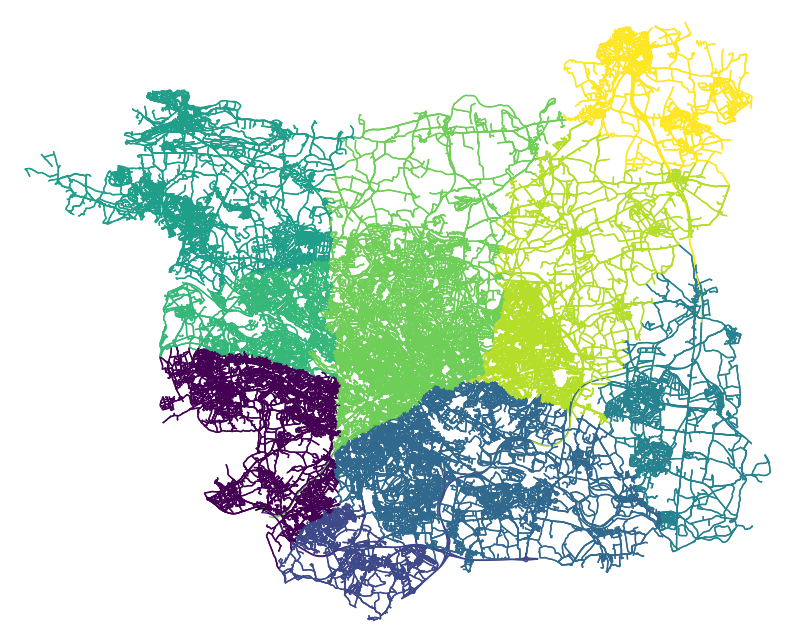

In [179]:
# Plot the paths found by find_cycles_around_42km
result_42km = find_marathon_path(graph, voronoi_cells,42000,0)
result_42km_list = [lst for value in result_42km.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km, node_colors, edge_colors)


seed: 446295571, length: 42123.78 m
seed: 319387, length: 41975.64 m
seed: 319599, length: 42028.14 m
seed: 10389165, length: 41971.45 m
seed: 3469066, length: 41944.71 m
seed: 154962, length: 42055.54 m


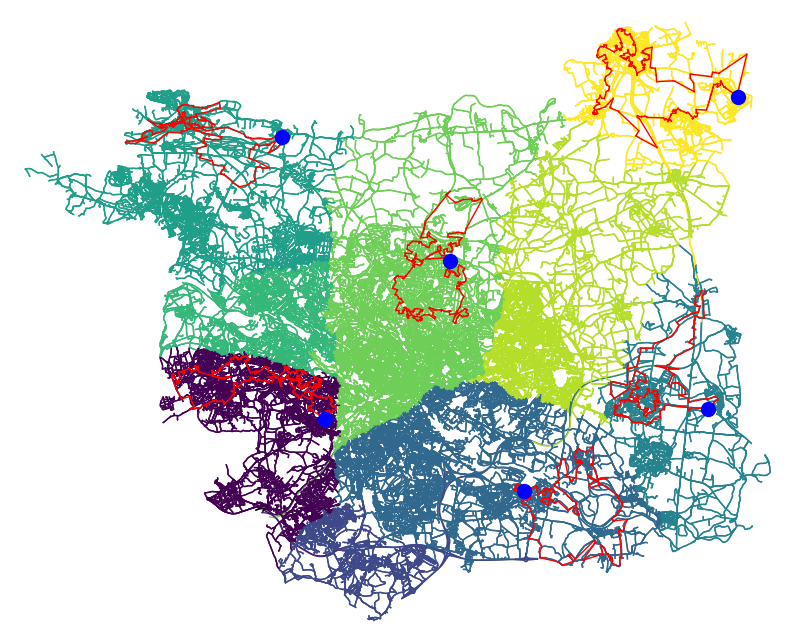

In [180]:
result_42km_tolerance = find_marathon_path(graph, voronoi_cells, 42000,150)
result_42km_tolerance_list = [lst for value in result_42km_tolerance.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_tolerance_list, node_colors, edge_colors)

**Try increasing the number of seeds based on the same criteria**

In [143]:
cell_boundaries2 = divide_leeds_into_cells(leeds_boundary, 50)
seeds2 = find_least_accident_area_in_cells(
    leeds_network, least_accident_nodes, cell_boundaries2)

In [144]:
seeds2 = GeoDataFrame(geometry=[Point(leeds_network.nodes[node]['x'], leeds_network.nodes[node]['y']) for node in seeds2])
seeds2['x'] = seeds2.geometry.x
seeds2['y'] = seeds2.geometry.y
print(seeds2)

                     geometry         x          y
0   POINT (-1.66568 53.74832) -1.665682  53.748320
1   POINT (-1.63198 53.74639) -1.631982  53.746388
2   POINT (-1.56897 53.73347) -1.568968  53.733472
3   POINT (-1.53408 53.71520) -1.534082  53.715197
4   POINT (-1.51412 53.74169) -1.514124  53.741694
5   POINT (-1.44989 53.72863) -1.449892  53.728634
6   POINT (-1.41955 53.72505) -1.419546  53.725049
7   POINT (-1.36955 53.74628) -1.369552  53.746277
8   POINT (-1.32245 53.74506) -1.322452  53.745064
9   POINT (-1.67513 53.75231) -1.675132  53.752310
10  POINT (-1.62102 53.79604) -1.621024  53.796040
11  POINT (-1.58902 53.77112) -1.589021  53.771122
12  POINT (-1.52261 53.77033) -1.522614  53.770331
13  POINT (-1.49908 53.76173) -1.499078  53.761726
14  POINT (-1.45550 53.74940) -1.455502  53.749402
15  POINT (-1.42598 53.74941) -1.425979  53.749412
16  POINT (-1.37724 53.76438) -1.377243  53.764382
17  POINT (-1.31371 53.77956) -1.313706  53.779561
18  POINT (-1.70772 53.81436) -

In [145]:
nearest_nodes2 = ox.distance.nearest_nodes(leeds_network, seeds2.x, seeds2.y)
voronoi_cells2, node_seed_dict2 = get_cells(leeds_network, nearest_nodes2)

No path found.


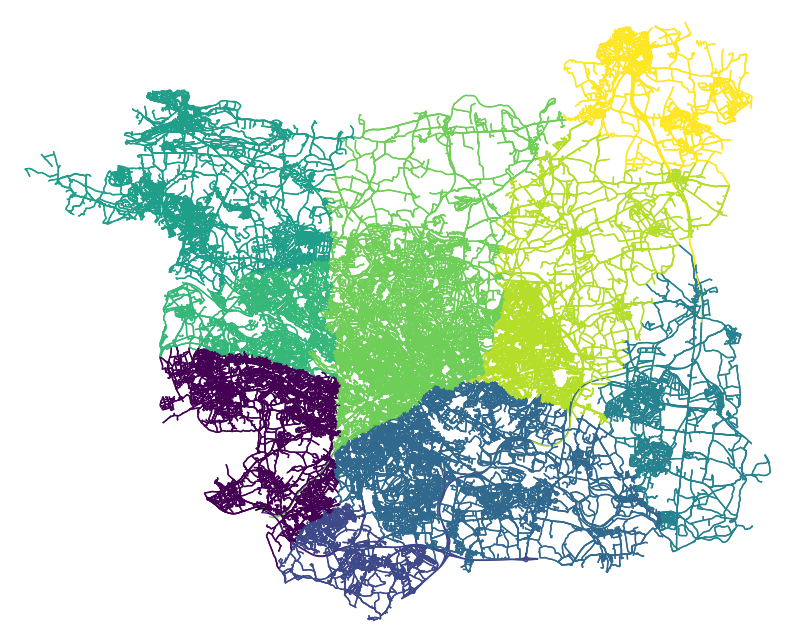

In [146]:
result_42km_2 = find_marathon_path(graph, voronoi_cells2,42000,0)
result_42km_2_list = [lst for value in result_42km_2.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_2_list, node_colors, edge_colors)

seed: 643907, length: 41957.85 m


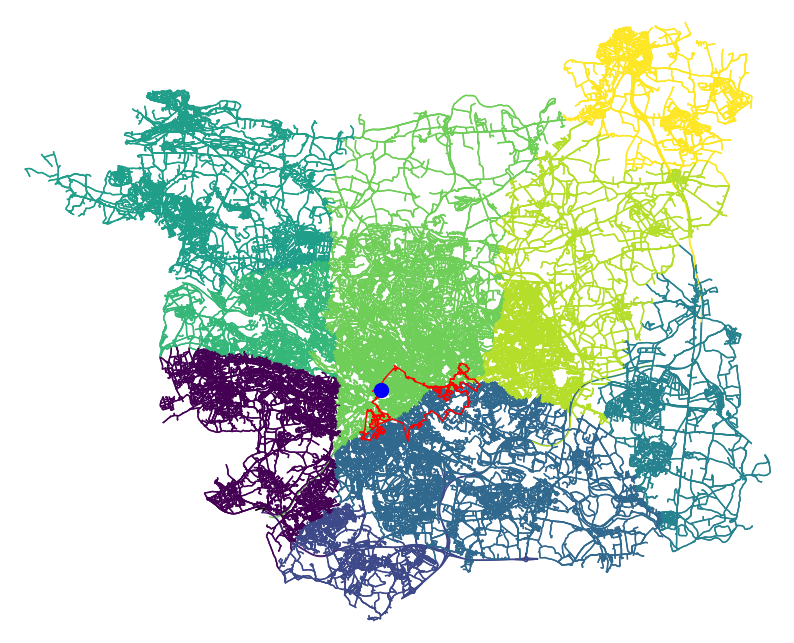

In [177]:
result_42km_2 = find_marathon_path(graph, voronoi_cells2,42000,150)
result_42km_2_list = [lst for value in result_42km_2.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_2_list, node_colors, edge_colors)

**Try using centroid nodes from leeds division instead of finding area that has least accident in each cell**

                     geometry         x          y
0   POINT (-1.70582 53.78323) -1.705821  53.783231
1   POINT (-1.67569 53.75233) -1.675692  53.752329
2   POINT (-1.61839 53.74043) -1.618391  53.740431
3   POINT (-1.54463 53.73992) -1.544632  53.739920
4   POINT (-1.47336 53.73882) -1.473358  53.738823
5   POINT (-1.39933 53.74038) -1.399332  53.740382
6   POINT (-1.32795 53.73809) -1.327951  53.738089
7   POINT (-1.76339 53.86642) -1.763393  53.866415
8   POINT (-1.69176 53.82393) -1.691763  53.823931
9   POINT (-1.61627 53.82310) -1.616269  53.823102
10  POINT (-1.54487 53.82247) -1.544869  53.822474
11  POINT (-1.47253 53.82218) -1.472530  53.822176
12  POINT (-1.40002 53.82121) -1.400020  53.821207
13  POINT (-1.32323 53.82123) -1.323234  53.821233
14  POINT (-1.78022 53.89258) -1.780219  53.892575
15  POINT (-1.69097 53.90465) -1.690968  53.904646
16  POINT (-1.61673 53.90311) -1.616729  53.903113
17  POINT (-1.54528 53.90293) -1.545285  53.902932
18  POINT (-1.47430 53.90213) -

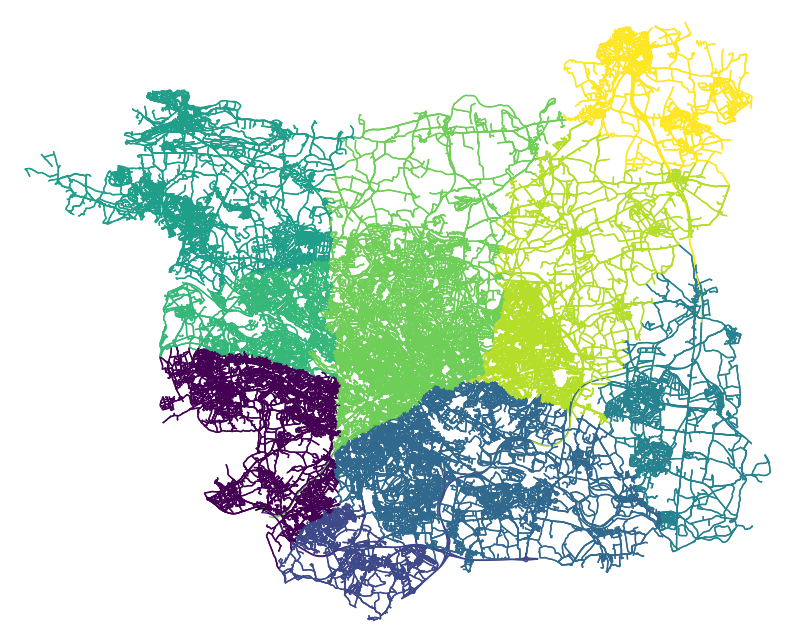

In [71]:
def find_centroid_nodes(graph, divided_areas):
    centroid_nodes = []

    # Get the nearest node to each centroid
    for area_boundary in divided_areas:
        minx, miny, maxx, maxy = area_boundary

        # Calculate the centroid of the cell boundary
        centroid_x = (minx + maxx) / 2
        centroid_y = (miny + maxy) / 2

        min_distance = float('inf')
        nearest_node = None

        # Iterate over all nodes in the graph
        for node in graph.nodes():
            node_x = graph.nodes[node]['x']
            node_y = graph.nodes[node]['y']

            # Calculate the Euclidean distance between the node and the centroid
            distance = math.sqrt((node_x - centroid_x) ** 2 + (node_y - centroid_y) ** 2)

            # Update the nearest node if the distance is smaller
            if distance < min_distance:
                min_distance = distance
                nearest_node = node

        centroid_nodes.append(nearest_node)

    return centroid_nodes




cell_boundaries3 = divide_leeds_into_cells(leeds_boundary, num_areas=20)
seeds3 = find_centroid_nodes(leeds_network, cell_boundaries3)
seeds3 = GeoDataFrame(geometry=[Point(leeds_network.nodes[node]['x'], leeds_network.nodes[node]['y']) for node in seeds3])
seeds3['x'] = seeds3.geometry.x
seeds3['y'] = seeds3.geometry.y
print(seeds3)
nearest_nodes3 = ox.distance.nearest_nodes(leeds_network, seeds3.x, seeds3.y)
voronoi_cells3, node_seed_dict3 = get_cells(leeds_network, nearest_nodes3)
result_42km_3 = find_marathon_path(graph, voronoi_cells3,42000,0)
result_42km_3_list = [lst for value in result_42km_3.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_3_list, node_colors, edge_colors)

seed: 456034959, length: 41944.53 m
seed: 6875454536, length: 42014.30 m


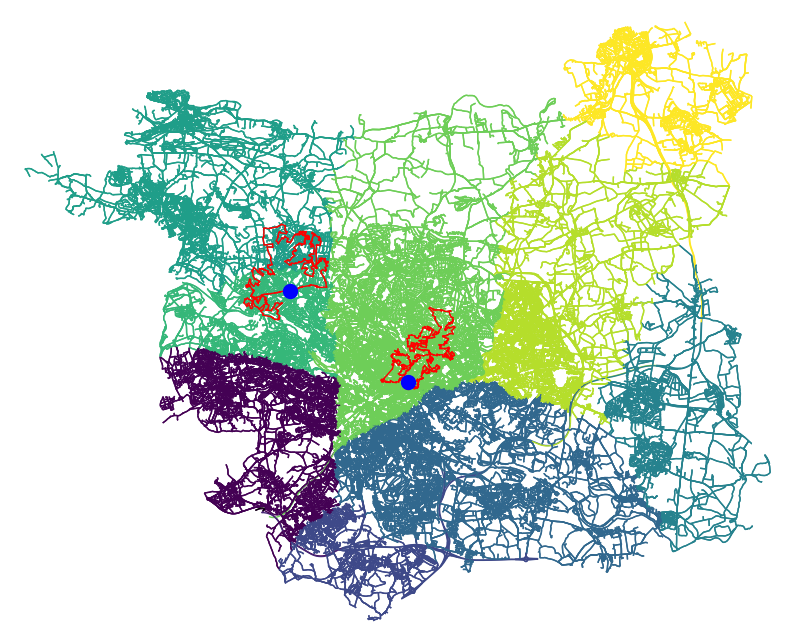

In [176]:
result_42km_3 = find_marathon_path(graph, voronoi_cells3,42000,150)
result_42km_3_list = [lst for value in result_42km_3.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_3_list, node_colors, edge_colors)

**Try using public transportation as seeds criteria**

In [73]:
import osmnx as ox
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Fetch bus stop locations using OSMnx
leeds_stations = ox.geometries_from_place('Leeds, UK', tags={'public_transport': 'stop_position'})
leeds_stations_df = pd.DataFrame({'latitude': leeds_stations.geometry.apply(lambda p: p.y),
                                  'longitude': leeds_stations.geometry.apply(lambda p: p.x)})

# Convert latitude and longitude values to radians and store them in a NumPy array
X = np.radians(leeds_stations_df[['latitude', 'longitude']])

# Instantiate a KMeans object with the desired number of clusters and fit it to the data
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(X)

# Find the closest data point in the dataset to each of the cluster centers, and store the indices of those points
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)

# Retrieve the coordinates of the cluster centers from the KMeans object, and convert them back to degrees
centroids = np.degrees(kmeans.cluster_centers_)

# Create GeoDataFrame for seed points
seeds4 = GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in centroids], columns=['geometry'])

# Print out the seed points
print(seeds4)




C:\Users\patta\AppData\Local\Temp\ipykernel_18836\3888852160.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  leeds_stations = ox.geometries_from_place('Leeds, UK', tags={'public_transport': 'stop_position'})
C:\Users\patta\anaconda3\envs\nda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


                    geometry
0  POINT (-1.62808 53.89097)
1  POINT (-1.38040 53.77621)
2  POINT (-1.54711 53.79542)
3  POINT (-1.46930 53.81117)
4  POINT (-1.36558 53.90863)
5  POINT (-1.61054 53.84079)
6  POINT (-1.34525 53.81518)
7  POINT (-1.68429 53.86202)
8  POINT (-1.70263 53.90207)
9  POINT (-1.43000 53.81623)


No path found.


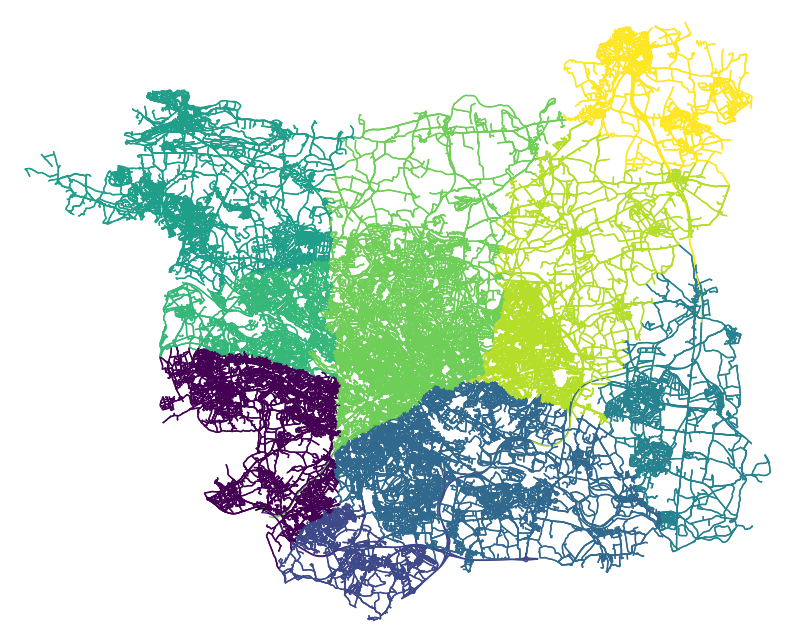

In [75]:
nearest_nodes4 = ox.distance.nearest_nodes(leeds_network, seeds4.geometry.x, seeds4.geometry.y)
voronoi_cells4, node_seed_dict4 = get_cells(leeds_network, nearest_nodes4)
result_42km_4 = find_marathon_path(graph, voronoi_cells4,42000,0)
result_42km_4_list = [lst for value in result_42km_4.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_4_list, node_colors, edge_colors)

seed: 8914061695, length: 41887.31 m
seed: 8731241661, length: 42008.65 m
seed: 2020515646, length: 42052.34 m


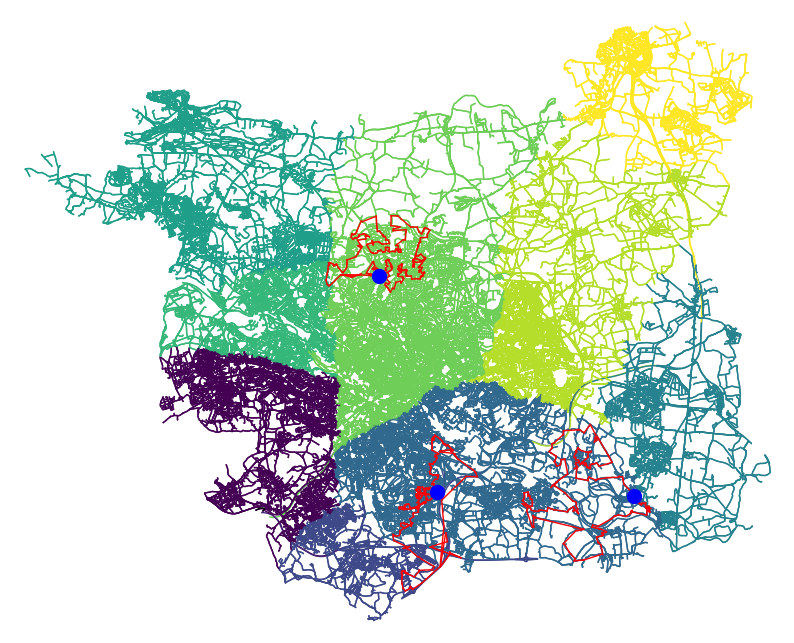

In [175]:
result_42km_4 = find_marathon_path(graph, voronoi_cells4,42000,150)
result_42km_4_list = [lst for value in result_42km_4.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_4_list, node_colors, edge_colors)

Try increasing the seeds number from public transport criteria

In [52]:
# Convert latitude and longitude values to radians and store them in a NumPy array
X = np.radians(leeds_stations_df[['latitude', 'longitude']])

# Instantiate a KMeans object with the desired number of clusters and fit it to the data
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans.fit(X)

# Find the closest data point in the dataset to each of the cluster centers, and store the indices of those points
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)

# Retrieve the coordinates of the cluster centers from the KMeans object, and convert them back to degrees
centroids = np.degrees(kmeans.cluster_centers_)

# Create GeoDataFrame for seed points
seeds5 = GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in centroids], columns=['geometry'])

# Print out the seed points
print(seeds5)

                     geometry
0   POINT (-1.60213 53.85006)
1   POINT (-1.43468 53.80656)
2   POINT (-1.71080 53.87365)
3   POINT (-1.32896 53.79210)
4   POINT (-1.54139 53.79645)
5   POINT (-1.34778 53.90159)
6   POINT (-1.62743 53.89121)
7   POINT (-1.63301 53.83675)
8   POINT (-1.69695 53.90809)
9   POINT (-1.37469 53.75871)
10  POINT (-1.67803 53.86064)
11  POINT (-1.46626 53.80397)
12  POINT (-1.45381 53.82934)
13  POINT (-1.34947 53.83364)
14  POINT (-1.56775 53.76596)
15  POINT (-1.57791 53.81255)
16  POINT (-1.40420 53.83662)
17  POINT (-1.50003 53.80316)
18  POINT (-1.38439 53.79039)
19  POINT (-1.39791 53.92485)


C:\Users\patta\anaconda3\envs\nda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


No path found.


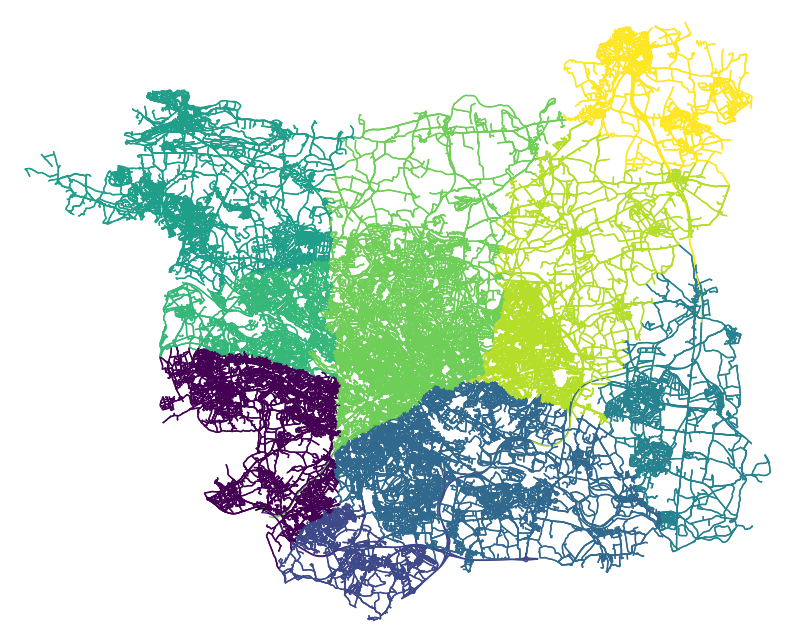

In [115]:
nearest_nodes5 = ox.distance.nearest_nodes(leeds_network, seeds5.geometry.x, seeds5.geometry.y)
voronoi_cells5, node_seed_dict5 = get_cells(leeds_network, nearest_nodes5)
result_42km_5 = find_marathon_path(graph, voronoi_cells5,42000,0)
result_42km_5_list = [lst for value in result_42km_5.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_5_list, node_colors, edge_colors)

seed: 7449158514, length: 42000.11 m
seed: 278829804, length: 41874.29 m
seed: 1625378095, length: 42126.06 m
seed: 8890823016, length: 42044.25 m


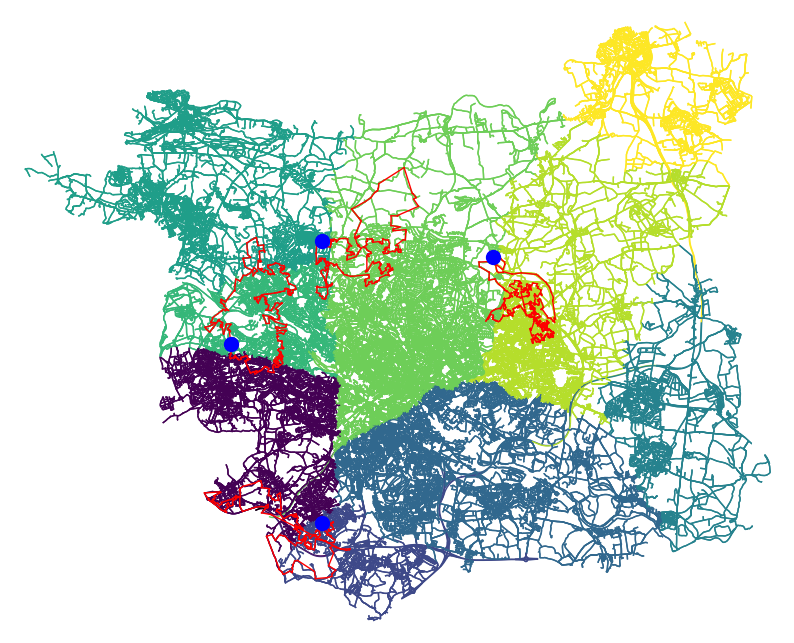

In [174]:
result_42km_5 = find_marathon_path(graph, voronoi_cells5,42000,150)
result_42km_5_list = [lst for value in result_42km_5.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_5_list, node_colors, edge_colors)

Getting more seeds by combining the criteria of:
- seeds from least accident area in each leeds division
- seeds from public transportation criteria
- increase number of seeds

Get voronoi cells from equally distributed areas and least accident criteria

In [151]:
voronoi_cells_combination={}
voronoi_cells_combination.update(voronoi_cells)

Combine the above voronoi cells with public transportation which already have 20 seeds

In [152]:
voronoi_cells_combination.update(voronoi_cells5)

In [156]:
len(voronoi_cells_combination)


31

This function is similar to the find_marathon_path function. The difference is that it will return only the path that is nearest to 42 km for each cell.

In [169]:
def find_marathon_path2(graph, voronoi_cells, km, tolerance):
    result = {}
    for seed, cells in voronoi_cells.items():
        subgraph = graph.subgraph(cells)
        cycles = nx.cycle_basis(subgraph)
        closest_length = float('inf')  # Initialize with a large value
        closest_path = None
        for cycle in cycles:
            length = sum(subgraph.edges[cycle[i], cycle[i+1]]['length'] for i in range(len(cycle) - 1))
            length += subgraph.edges[cycle[-1], cycle[0]]['length']
            if km - tolerance <= length <= km + tolerance:
                if abs(length - km) < abs(closest_length - km):
                    closest_length = length
                    closest_path = cycle
        if closest_path:
            result[seed] = [(closest_path, closest_length)]
            print("seed: {}, length: {:.2f} m".format(seed, closest_length))
    return result

seed: 446295571, length: 42123.78 m
seed: 319387, length: 41975.64 m
seed: 319599, length: 42028.14 m
seed: 10389165, length: 41971.45 m
seed: 3469066, length: 41944.71 m
seed: 154962, length: 42055.54 m
seed: 7449158514, length: 42000.11 m
seed: 278829804, length: 41874.29 m
seed: 1625378095, length: 42126.06 m
seed: 8890823016, length: 42044.25 m


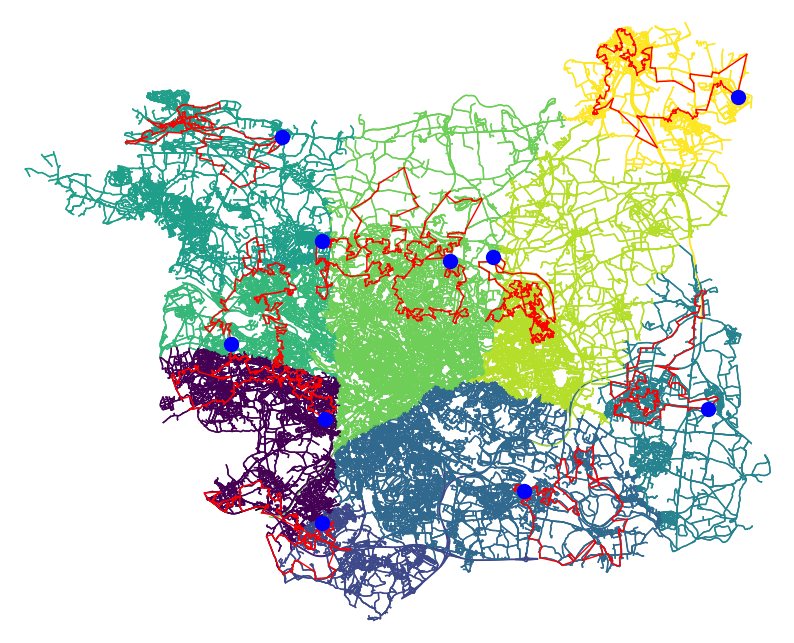

In [173]:
result_42km_6 = find_marathon_path2(graph, voronoi_cells_combination,42000,150)
result_42km_6_list = [lst for value in result_42km_6.values() for lst, _ in value]
plot_marathon_paths(leeds_network, result_42km_6_list, node_colors, edge_colors)